```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Job Search IV: Correlated Wage Offers

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon
!pip install interpolation

## Overview

In this lecture we solve a {doc}`McCall style job search model <mccall_model>` with persistent and
transitory components to wages.

In other words, we relax the unrealistic assumption that randomness in wages is independent over time.

At the same time, we will go back to assuming that jobs are permanent and no separation occurs.

This is to keep the model relatively simple as we study the impact of correlation.

We will use the following imports:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
import quantecon as qe
from interpolation import interp
from numpy.random import randn
from numba import njit, prange, float64
from numba.experimental import jitclass

## The Model

Wages at each point in time are given by

$$
w_t = \exp(z_t) + y_t
$$

where

$$
y_t \sim \exp(\mu + s \zeta_t)
\quad \text{and} \quad
z_{t+1} = d + \rho z_t + \sigma \epsilon_{t+1}
$$

Here $\{ \zeta_t \}$ and $\{ \epsilon_t \}$ are both IID and standard normal.

Here $\{y_t\}$ is a transitory component and $\{z_t\}$ is persistent.

As before, the worker can either

1. accept an offer and work permanently at that wage, or
1. take unemployment compensation $c$ and wait till next period.

The value function satisfies the Bellman equation

$$
v^*(w, z) =
    \max
    \left\{
        \frac{u(w)}{1-\beta}, u(c) + \beta \, \mathbb E_z v^*(w', z')
    \right\}
$$

In this express, $u$ is a utility function and $\mathbb E_z$ is expectation of next period variables given current $z$.

The variable $z$ enters as a state in the Bellman equation because its current value helps predict future wages.

### A Simplification

There is a way that we can reduce dimensionality in this problem, which greatly accelerates computation.

To start, let $f^*$ be the continuation value function, defined
by

$$
f^*(z) := u(c) + \beta \, \mathbb E_z v^*(w', z')
$$

The Bellman equation can now be written

$$
v^*(w, z) = \max \left\{ \frac{u(w)}{1-\beta}, \, f^*(z) \right\}
$$

Combining the last two expressions, we see that the continuation value
function satisfies

$$
f^*(z) = u(c) + \beta \, \mathbb E_z \max \left\{ \frac{u(w')}{1-\beta}, f^*(z') \right\}
$$

We’ll solve this functional equation for $f^*$ by introducing the
operator

$$
Qf(z) = u(c) + \beta \, \mathbb E_z \max \left\{ \frac{u(w')}{1-\beta}, f(z') \right\}
$$

By construction, $f^*$ is a fixed point of $Q$, in the sense that
$Q f^* = f^*$.

Under mild assumptions, it can be shown that $Q$ is a [contraction mapping](https://en.wikipedia.org/wiki/Contraction_mapping) over a suitable space of continuous functions on $\mathbb R$.

By Banach's contraction mapping theorem, this means that $f^*$ is the unique fixed point and we can calculate it by iterating with $Q$ from any reasonable initial condition.

Once we have $f^*$, we can solve the search problem by stopping when the reward for accepting exceeds the continuation value, or

$$
\frac{u(w)}{1-\beta} \geq f^*(z)
$$

For utility we take $u(c) = \ln(c)$.

The reservation wage is the wage where equality holds in the last expression.

That is,

```{math}
:label: corr_mcm_barw

\bar w (z) := \exp(f^*(z) (1-\beta))
```

Our main aim is to solve for the reservation rule and study its properties and implications.

## Implementation

Let $f$ be our initial guess of $f^*$.

When we iterate, we use the {doc}`fitted value function iteration <mccall_fitted_vfi>` algorithm.

In particular, $f$ and all subsequent iterates are stored as a vector of values on a grid.

These points are interpolated into a function as required, using piecewise linear interpolation.

The integral in the definition of $Qf$ is calculated by Monte Carlo.

The following list helps Numba by providing some type information about the data we will work with.

In [3]:
job_search_data = [
     ('μ', float64),             # transient shock log mean
     ('s', float64),             # transient shock log variance
     ('d', float64),             # shift coefficient of persistent state
     ('ρ', float64),             # correlation coefficient of persistent state
     ('σ', float64),             # state volatility
     ('β', float64),             # discount factor
     ('c', float64),             # unemployment compensation
     ('z_grid', float64[:]),     # grid over the state space
     ('e_draws', float64[:,:])   # Monte Carlo draws for integration
]

Here's a class that stores the data and the right hand side of the Bellman equation.

Default parameter values are embedded in the class.

In [4]:
@jitclass(job_search_data)
class JobSearch:

    def __init__(self,
                 μ=0.0,       # transient shock log mean
                 s=1.0,       # transient shock log variance
                 d=0.0,       # shift coefficient of persistent state
                 ρ=0.9,       # correlation coefficient of persistent state
                 σ=0.1,       # state volatility
                 β=0.98,      # discount factor
                 c=5,         # unemployment compensation
                 mc_size=1000,
                 grid_size=100):

        self.μ, self.s, self.d,  = μ, s, d,
        self.ρ, self.σ, self.β, self.c = ρ, σ, β, c

        # Set up grid
        z_mean = d / (1 - ρ)
        z_sd = np.sqrt(σ / (1 - ρ**2))
        k = 3  # std devs from mean
        a, b = z_mean - k * z_sd, z_mean + k * z_sd
        self.z_grid = np.linspace(a, b, grid_size)

        # Draw and store shocks
        np.random.seed(1234)
        self.e_draws = randn(2, mc_size)

    def parameters(self):
        """
        Return all parameters as a tuple.
        """
        return self.μ, self.s, self.d, \
                self.ρ, self.σ, self.β, self.c

Next we implement the $Q$ operator.

In [5]:
@njit(parallel=True)
def Q(js, f_in, f_out):
    """
    Apply the operator Q.

        * js is an instance of JobSearch
        * f_in and f_out are arrays that represent f and Qf respectively

    """

    μ, s, d, ρ, σ, β, c = js.parameters()
    M = js.e_draws.shape[1]

    for i in prange(len(js.z_grid)):
        z = js.z_grid[i]
        expectation = 0.0
        for m in range(M):
            e1, e2 = js.e_draws[:, m]
            z_next = d + ρ * z + σ * e1
            go_val = interp(js.z_grid, f_in, z_next)     # f(z')
            y_next = np.exp(μ + s * e2)                  # y' draw
            w_next = np.exp(z_next) + y_next             # w' draw
            stop_val = np.log(w_next) / (1 - β)
            expectation += max(stop_val, go_val)
        expectation = expectation / M
        f_out[i] = np.log(c) + β * expectation

Here's a function to compute an approximation to the fixed point of $Q$.

In [6]:
def compute_fixed_point(js,
                        use_parallel=True,
                        tol=1e-4,
                        max_iter=1000,
                        verbose=True,
                        print_skip=25):

    f_init = np.full(len(js.z_grid), np.log(js.c))
    f_out = np.empty_like(f_init)

    # Set up loop
    f_in = f_init
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        Q(js, f_in, f_out)
        error = np.max(np.abs(f_in - f_out))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        f_in[:] = f_out

    if error > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"\nConverged in {i} iterations.")

    return f_out

Let's try generating an instance and solving the model.

In [7]:
js = JobSearch()

qe.tic()
f_star = compute_fixed_point(js, verbose=True)
qe.toc()

Error at iteration 25 is 0.6540143893175951.
Error at iteration 50 is 0.12643184012380004.
Error at iteration 75 is 0.030376323858035903.
Error at iteration 100 is 0.007581959253954551.
Error at iteration 125 is 0.0019085682645538782.


Error at iteration 150 is 0.00048173786846916755.
Error at iteration 175 is 0.000121400125664195.

Converged in 179 iterations.
TOC: Elapsed: 0:00:2.21


2.214930772781372

Next we will compute and plot the reservation wage function defined in {eq}`corr_mcm_barw`.

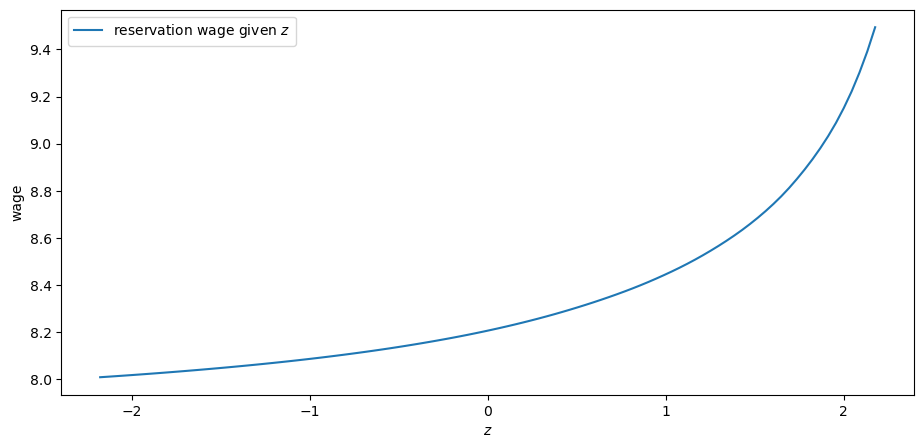

In [8]:
res_wage_function = np.exp(f_star * (1 - js.β))

fig, ax = plt.subplots()
ax.plot(js.z_grid, res_wage_function, label="reservation wage given $z$")
ax.set(xlabel="$z$", ylabel="wage")
ax.legend()
plt.show()

Notice that the reservation wage is increasing in the current state $z$.

This is because a higher state leads the agent to predict higher future wages,
increasing the option value of waiting.

Let's try changing unemployment compensation and look at its impact on the
reservation wage:

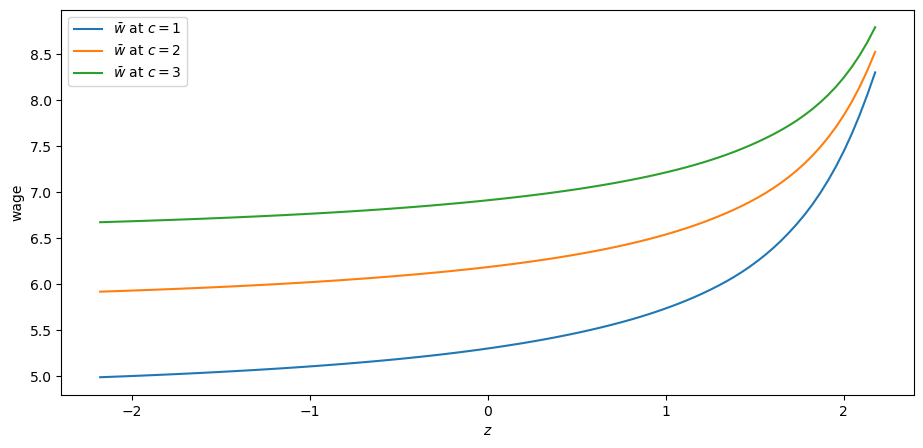

In [9]:
c_vals = 1, 2, 3

fig, ax = plt.subplots()

for c in c_vals:
    js = JobSearch(c=c)
    f_star = compute_fixed_point(js, verbose=False)
    res_wage_function = np.exp(f_star * (1 - js.β))
    ax.plot(js.z_grid, res_wage_function, label=rf"$\bar w$ at $c = {c}$")

ax.set(xlabel="$z$", ylabel="wage")
ax.legend()
plt.show()

As expected, higher unemployment compensation shifts the reservation wage up
at all state values.

## Unemployment Duration

Next we study how mean unemployment duration varies with unemployment compensation.

For simplicity we’ll fix the initial state at $z_t = 0$.

In [10]:
def compute_unemployment_duration(js, seed=1234):

    f_star = compute_fixed_point(js, verbose=False)
    μ, s, d, ρ, σ, β, c = js.parameters()
    z_grid = js.z_grid
    np.random.seed(seed)

    @njit
    def f_star_function(z):
        return interp(z_grid, f_star, z)

    @njit
    def draw_tau(t_max=10_000):
        z = 0
        t = 0

        unemployed = True
        while unemployed and t < t_max:
            # draw current wage
            y = np.exp(μ + s * np.random.randn())
            w = np.exp(z) + y
            res_wage = np.exp(f_star_function(z) * (1 - β))
            # if optimal to stop, record t
            if w >= res_wage:
                unemployed = False
                τ = t
            # else increment data and state
            else:
                z = ρ * z + d + σ * np.random.randn()
                t += 1
        return τ

    @njit(parallel=True)
    def compute_expected_tau(num_reps=100_000):
        sum_value = 0
        for i in prange(num_reps):
            sum_value += draw_tau()
        return sum_value / num_reps

    return compute_expected_tau()

Let's test this out with some possible values for unemployment compensation.

In [11]:
c_vals = np.linspace(1.0, 10.0, 8)
durations = np.empty_like(c_vals)
for i, c in enumerate(c_vals):
    js = JobSearch(c=c)
    τ = compute_unemployment_duration(js)
    durations[i] = τ

Here is a plot of the results.

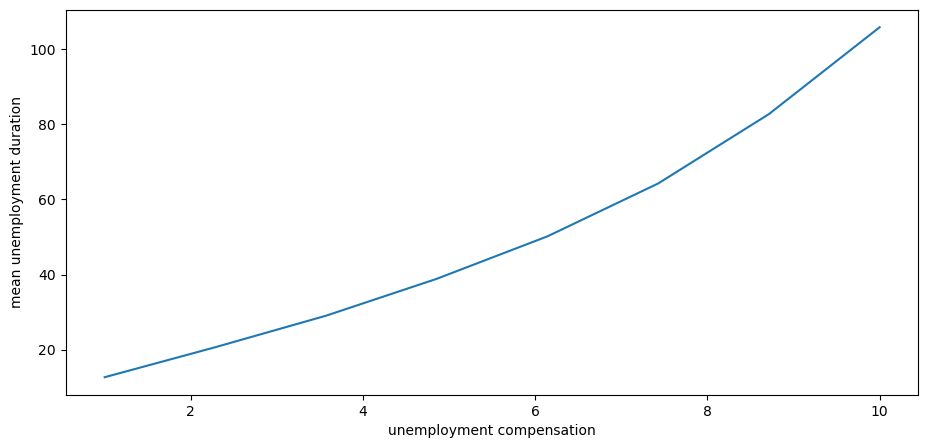

In [12]:
fig, ax = plt.subplots()
ax.plot(c_vals, durations)
ax.set_xlabel("unemployment compensation")
ax.set_ylabel("mean unemployment duration")
plt.show()

Not surprisingly, unemployment duration increases when unemployment compensation is higher.

This is because the value of waiting increases with unemployment compensation.

## Exercises

```{exercise}
:label: mc_ex1

Investigate how mean unemployment duration varies with the discount factor $\beta$.

* What is your prior expectation?
* Do your results match up?
```

```{solution-start} mc_ex1
:class: dropdown
```

Here is one solution

In [13]:
beta_vals = np.linspace(0.94, 0.99, 8)
durations = np.empty_like(beta_vals)
for i, β in enumerate(beta_vals):
    js = JobSearch(β=β)
    τ = compute_unemployment_duration(js)
    durations[i] = τ

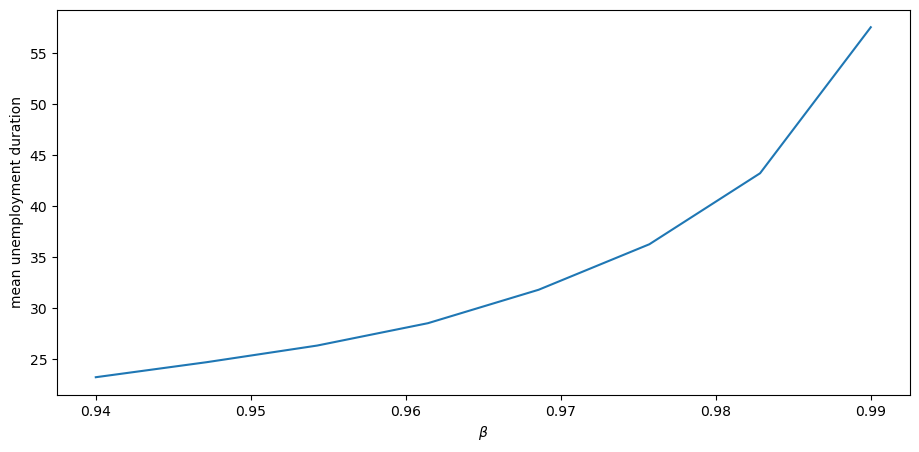

In [14]:
fig, ax = plt.subplots()
ax.plot(beta_vals, durations)
ax.set_xlabel(r"$\beta$")
ax.set_ylabel("mean unemployment duration")
plt.show()

The figure shows that more patient individuals tend to wait longer before accepting an offer.

```{solution-end}
```